### Project Name: Exploring Bank Transaction Dataset

#### Project Members:
1. Piyush Borse&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(25PGAI0026)
2. Prateek Majumder&ensp;&ensp;&ensp;(25PGAI0027)
3. Neha Roy Choudhury&ensp;(25PGAI0096)
4. Yuvraj Singh Srinet&ensp;&ensp;&ensp;&ensp;(25PGAI0019)
5. Bhawana Thawarani&ensp;&ensp;(25PGAI0137)
6. Prajwal Wagh&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(25PGAI0109)

In [0]:
#DatasetLink :- https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation
#/FileStore/tables/bank_transactions.csv

###Bank Customer Segmentation
Most banks have a large customer base - with different characteristics in terms of age, income, values, lifestyle, and more. Customer segmentation is the process of dividing a customer dataset into specific groups based on shared traits.

According to a report from Ernst & Young, “A more granular understanding of consumers is no longer a nice-to-have item, but a strategic and competitive imperative for banking providers. Customer understanding should be a living, breathing part of everyday business, with insights underpinning the full range of banking operations.

###About this Dataset
This dataset consists of 1 Million+ transaction by over 800K customers for a bank in India. The data contains information such as - customer age (DOB), location, gender, account balance at the time of the transaction, transaction details, transaction amount, etc.

###Interesting Analysis Ideas
The dataset can be used for different analysis, example -

1. Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
2. Perform Location-wise analysis to identify regional trends in India
3. Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
4. Customer Recency, Frequency, Monetary analysis
5. Network analysis or Graph analysis of customer data.

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Loading the dataset

Data is provided in *csv* format and contains header in the first line. Spark provides *sqlContext.read.csv* to read the csv data and create the dataframe. Spark can automatically infer the schema from the data if *inferSchema* is set to True.

In [0]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Big Data Engineering Project") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [0]:
#Importing Libraries
from pyspark.sql.functions import col, sum as _sum, to_date, lit,date_format
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.window import Window
from pyspark.sql.functions import col, sum, rank, round, max, avg, to_date, datediff, floor
from pyspark.sql.window import Window

In [0]:
%fs ls /FileStore/tables/bank_transactions.csv

path,name,size,modificationTime
dbfs:/FileStore/tables/bank_transactions.csv,bank_transactions.csv,67564190,1720884741000


##Read records using Custom Schema
We can also read the data using our own custom defined schema. For example, Date column can be read as DateType rather than Timestamp, it is mostly contains the date information.

In [0]:
#%fs head /FileStore/tables/bank_transactions.csv

These are th fields in the Dataset:
1. TransactionID: a unique Id for each transaction
2. CustomerID: a unique Id for each customer
3. CustomerDOB: Date of Birth of customer (will be helpful to calculate age)
4. CustGender: Gender of customer
5. CustLocation: location of customer
6. CustAccountBalance: Account Balance of customer
7. TransactionDate: Date of the Transaction
8. TransactionTime: Time of the Transaction
9. TransactionAmount (INR): Amount of the Transaction

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("Big Data Engineering Project").getOrCreate()

# Define schema
schema = StructType([
    StructField("TransactionID", StringType(), True),
    StructField("CustomerID", StringType(), True),
    StructField("CustomerDOB", StringType(), True),
    StructField("CustGender", StringType(), True),
    StructField("CustLocation", StringType(), True),
    StructField("CustAccountBalance", FloatType(), True),
    StructField("TransactionDate", StringType(), True),
    StructField("TransactionTime", StringType(), True),
    StructField("TransactionAmount", FloatType(), True)
])

In [0]:
bank_df = spark.read.csv("dbfs:/FileStore/tables/bank_transactions.csv", 
                                header = True,
                                schema = StructType(schema) )
bank_df.cache()
bank_df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: string (nullable = true)
 |-- TransactionTime: string (nullable = true)
 |-- TransactionAmount: float (nullable = true)



In [0]:
bank_df.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|           T1|  C5841053|    10/1/94|         F|  JAMSHEDPUR|          17819.05|         2/8/16|         143207|             25.0|
|           T2|  C2142763|     4/4/57|         M|     JHAJJAR|           2270.69|         2/8/16|         141858|          27999.0|
|           T3|  C4417068|   26/11/96|         F|      MUMBAI|          17874.44|         2/8/16|         142712|            459.0|
|           T4|  C5342380|    14/9/73|         F|      MUMBAI|          866503.2|         2/8/16|         142714|           2060.0|
|           T5|  C9031234|    24/3/88|         F| NAVI MUMBAI|           671

##2. Data Transformation and Cleaning
- Convert date strings to date type
- Handle missing values
- Filter out invalid data (e.g., unrealistic DOBs)

In [0]:
# Convert date columns to date type
bank_df = bank_df.withColumn("CustomerDOB", to_date(col("CustomerDOB"), "d/M/yy"))

bank_df = bank_df.withColumn("TransactionDate", to_date(col("TransactionDate"), "d/M/yy"))

In [0]:
bank_df.show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|           T1|  C5841053| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|         143207|             25.0|
|           T2|  C2142763| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|         141858|          27999.0|
|           T3|  C4417068| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|         142712|            459.0|
|           T4|  C5342380| 1973-09-14|         F|      MUMBAI|          866503.2|     2016-08-02|         142714|           2060.0|
|           T5|  C9031234| 1988-03-24|         F| NAVI MUMBAI|           671

In [0]:
# Handle missing values (e.g., fill with average or drop)
bank_df = bank_df.fillna({"CustAccountBalance": 0, "TransactionAmount": 0})

# Filter out unrealistic DOBs
bank_df = bank_df.filter(col("CustomerDOB") > lit("1900-01-01"))

bank_df.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|           T1|  C5841053| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|         143207|             25.0|
|           T2|  C2142763| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|         141858|          27999.0|
|           T3|  C4417068| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|         142712|            459.0|
|           T4|  C5342380| 1973-09-14|         F|      MUMBAI|          866503.2|     2016-08-02|         142714|           2060.0|
|           T5|  C9031234| 1988-03-24|         F| NAVI MUMBAI|           671

##3. Define Business Insights
Let's define seven key business insights we want to derive from the data:

1. Total Transaction Amount per Customer Location (Filter, Projection, Group By).
2. Top 3 Customers by Transaction Amount in Each Location (Partition Over Ranking Function).
3. Moving Average of Transaction Amount for Each Customer (Moving Average).
4. Gender-wise distribution of transactions.
5. Average account balance per location.
6. Highest transaction amount per day.
7. Customer age distribution.

##4. Pipeline Creation for Insights

###Insight 1:Total Transaction Amount per Customer Location (Filter, Projection, Group By)

In [0]:
#Data Preprocessing Step for insight1
df_clean = bank_df.filter(bank_df["CustomerID"].isNotNull() & bank_df["CustLocation"].isNotNull() & bank_df["TransactionAmount"].isNotNull())

In [0]:
# Get the latest transaction date to get age by subtracting it from customer DOB
latest_transaction_date = df_clean.agg(max("TransactionDate").alias("LatestTransactionDate")).collect()[0]["LatestTransactionDate"]

print(f"The latest transaction date is: {latest_transaction_date}")

The latest transaction date is: 2016-10-21


In [0]:
# Define the current date (2016-10-21) as last transaction date is 2016-10-21
current_date = '2016-10-21'

# Convert CustomerDOB to date format
df_clean = df_clean.withColumn('CustomerDOB', to_date(col('CustomerDOB'), 'dd-MM-yyyy'))

# Calculate age
df_clean = df_clean.withColumn('Age', floor(datediff(to_date(lit(current_date)), col('CustomerDOB')) / 365))

#Filtering customers with age more than 18
df_clean = df_clean.filter(col('Age')>=18)

# Group by CustLocation and calculate the total transaction amount rounded to 2 decimal places
location_transaction_amount = df_clean.groupBy("CustLocation") \
    .agg(round(sum("TransactionAmount"), 2).alias("TotalTransactionAmount"))

In [0]:
# Convert to Pandas DataFrame for plotting
location_transaction_amount_pd = location_transaction_amount.toPandas()
location_transaction_amount_pd = location_transaction_amount_pd.sort_values(by="TotalTransactionAmount", ascending=False).head(20)

In [0]:
location_transaction_amount_pd['TotalTransactionAmount'] = location_transaction_amount_pd['TotalTransactionAmount'].apply(lambda x:int(x/1000000))

In [0]:
location_transaction_amount_pd.head()

,CustLocation,TotalTransactionAmount
4201,MUMBAI,160
241,NEW DELHI,129
1216,BANGALORE,105
3383,GURGAON,100
1215,DELHI,92


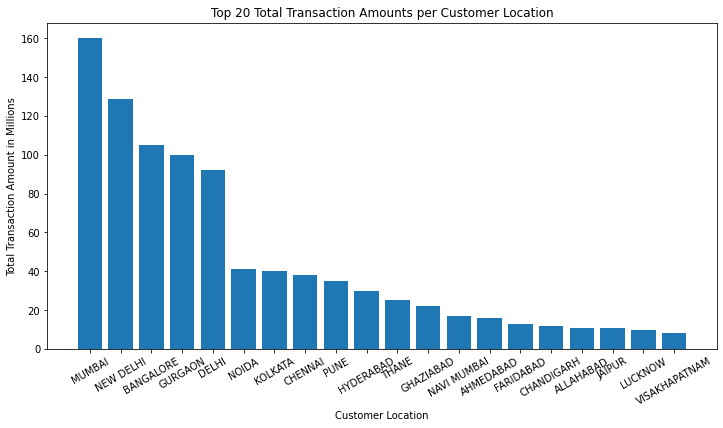

In [0]:
plt.figure(figsize=(12, 6))
plt.bar(location_transaction_amount_pd['CustLocation'], location_transaction_amount_pd['TotalTransactionAmount'])
plt.xlabel('Customer Location')
plt.ylabel('Total Transaction Amount in Millions')
plt.title('Top 20 Total Transaction Amounts per Customer Location')
plt.xticks(rotation=30)
plt.show()

#### Inference:
- This insight helps in identifying which locations generate the highest and lowest transaction amounts. 
- This can guide businesses in making location-specific strategies such as targeted marketing campaigns, resource allocation, and identifying regions that may need additional support or development efforts

###Insight 2: Top 3 Customers by Transaction Amount in Each Location (Partition Over Ranking Function)

In [0]:
# Step 1: Group by CustLocation and CustomerID, then calculate the total transaction amount
location_customer_transaction = df_clean.groupBy("CustLocation", "CustomerID") \
    .agg(sum("TransactionAmount").alias("TotalTransactionAmount"))

# Step 2: Use a window function to rank the customers by transaction amount within each location
window_spec = Window.partitionBy("CustLocation").orderBy(col("TotalTransactionAmount").desc())
location_customer_transaction = location_customer_transaction.withColumn("rank", rank().over(window_spec))

# Step 3: Filter to get the top 3 customers in each location
top_3_customers_per_location = location_customer_transaction.filter(col("rank") <= 3)

# Step 4: Convert the resulting DataFrame to Pandas for plotting
top_3_customers_per_location_pd = top_3_customers_per_location.toPandas()



In [0]:
top_3_customers_per_location_pd.head()

,CustLocation,CustomerID,TotalTransactionAmount,rank
0,(N) 24 PGS,C8966067,2400.0,1
1,(N) 24 PGS,C2966067,1867.0,2
2,(N) 24 PGS,C1166072,1750.0,3
3,(VIA) SALEM,C6134174,3898.0,1
4,(VIA) SALEM,C8134142,3898.0,1


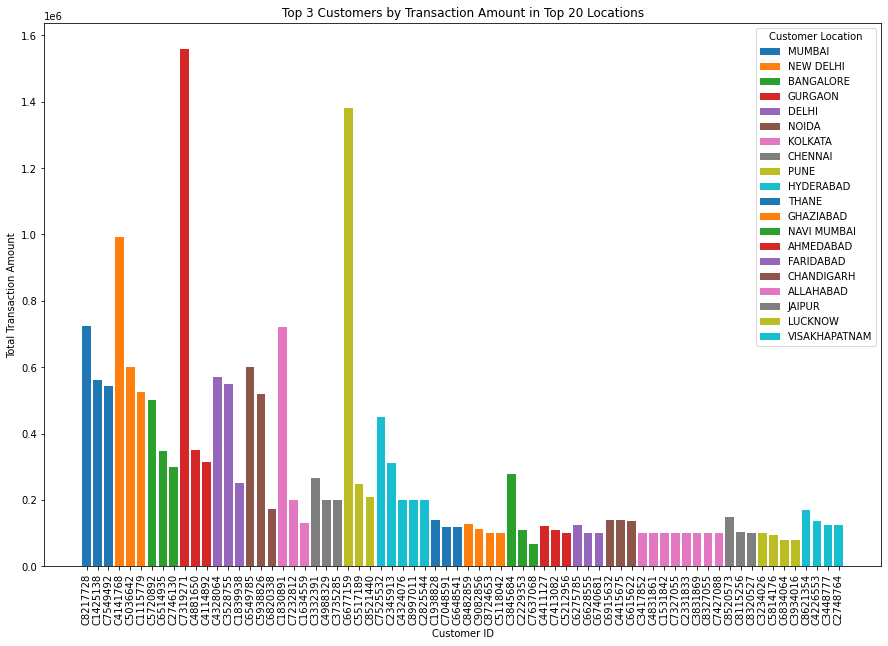

In [0]:
# Step 5: Plot the data
plt.figure(figsize=(15, 10))

# Iterate through each unique location and plot the top 3 customers
for location in location_transaction_amount_pd['CustLocation'].unique():
    location_data = top_3_customers_per_location_pd[top_3_customers_per_location_pd['CustLocation'] == location]
    plt.bar(location_data['CustomerID'], location_data['TotalTransactionAmount'], label=location)

plt.xlabel('Customer ID')
plt.ylabel('Total Transaction Amount')
plt.title('Top 3 Customers by Transaction Amount in Top 20 Locations')
plt.xticks(rotation=90)
plt.legend(title='Customer Location')
plt.show()

### Inference:
- This insight reveals the most valuable customers in each location, allowing businesses to focus on retaining and nurturing these top customers. 
- This can be done through personalized offers, loyalty programs, and enhanced customer service. It also highlights which locations have high-value customers.

In [0]:

'''###More Insights: Total transaction amount per customer

# Convert DataFrame to RDD
rdd = bank_df.rdd

# Example MapReduce: Calculate total transaction amount per customer using RDD
def map_function(row):
    return (row['CustomerID'], row['TransactionAmount'])

def reduce_function(a, b):
    return a + b

total_transaction_amount_rdd = rdd.map(map_function).reduceByKey(reduce_function)
total_transaction_amount_rdd.collect()

# Convert to DataFrame for plotting
total_transaction_amount_rdd_df = total_transaction_amount_rdd.toDF(["CustomerID", "TotalTransactionAmount"]).toPandas()
# Plot total transaction amount per customer using RDD result
top_n = 20
top_customers_rdd = total_transaction_amount_rdd_df.nlargest(top_n, 'TotalTransactionAmount')

plt.figure(figsize=(10, 6))
plt.bar(top_customers_rdd['CustomerID'], top_customers_rdd['TotalTransactionAmount'])
plt.xlabel('Customer ID')
plt.ylabel('Total Transaction Amount')
plt.title('Top 20 Customers by Total Transaction Amount (RDD)')
plt.xticks(rotation=90)
plt.show()


###Insight 2: Average transaction amount per customer
# Average transaction amount per customer
average_transaction_amount = bank_df.groupBy("CustomerID").avg("TransactionAmount")
average_transaction_amount.show(10)'''

Out[22]: '###More Insights: Total transaction amount per customer\n\n# Convert DataFrame to RDD\nrdd = bank_df.rdd\n\n# Example MapReduce: Calculate total transaction amount per customer using RDD\ndef map_function(row):\n    return (row[\'CustomerID\'], row[\'TransactionAmount\'])\n\ndef reduce_function(a, b):\n    return a + b\n\ntotal_transaction_amount_rdd = rdd.map(map_function).reduceByKey(reduce_function)\ntotal_transaction_amount_rdd.collect()\n\n# Convert to DataFrame for plotting\ntotal_transaction_amount_rdd_df = total_transaction_amount_rdd.toDF(["CustomerID", "TotalTransactionAmount"]).toPandas()\n# Plot total transaction amount per customer using RDD result\ntop_n = 20\ntop_customers_rdd = total_transaction_amount_rdd_df.nlargest(top_n, \'TotalTransactionAmount\')\n\nplt.figure(figsize=(10, 6))\nplt.bar(top_customers_rdd[\'CustomerID\'], top_customers_rdd[\'TotalTransactionAmount\'])\nplt.xlabel(\'Customer ID\')\nplt.ylabel(\'Total Transaction Amount\')\nplt.title(\'Top 2

### Insight 3: Moving Average of Transaction Amount for Each Customer (Moving Average)

In [0]:
# Define window specification for moving average
window_spec = Window.partitionBy("CustomerID").orderBy("TransactionDate").rowsBetween(-3, 0)

# Calculate moving average
moving_avg_df = df_clean.withColumn("MovingAvgTransactionAmount", avg("TransactionAmount").over(window_spec))

# Show the result
moving_avg_df.show()

+-------------+----------+-----------+----------+--------------------+------------------+---------------+---------------+-----------------+---+--------------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount|Age|MovingAvgTransactionAmount|
+-------------+----------+-----------+----------+--------------------+------------------+---------------+---------------+-----------------+---+--------------------------+
|      T401396|  C1010024| 1965-06-21|         M|             KOLKATA|          87058.65|     2016-08-18|         141103|           5000.0| 51|                    5000.0|
|      T303294|  C1010068| 1976-07-14|         M|             GURGAON|          46741.73|     2016-08-10|         101617|            546.0| 40|                     546.0|
|      T113706|  C1010081| 1984-02-11|         F|              HOWRAH|             17.71|     2016-08-06|         145828|           2856.0| 32|  

###Inference:
- This insight helps in understanding the transaction trends of individual customers over time. The moving average smoothens short-term fluctuations and highlights longer-term trends. 
- Businesses can use this to identify changes in customer behavior, spot potential churn risks, and tailor marketing strategies accordingly.

### Insight 4: Gender Wise distribution of Transactions

In [0]:
# Filter by gender and calculate average transaction amount
average_transaction_amount_f = df_clean.filter(col("CustGender") == "F").agg(avg("TransactionAmount").alias("AverageTransactionAmount")).collect()
average_transaction_amount_m = df_clean.filter(col("CustGender") == "M").agg(avg("TransactionAmount").alias("AverageTransactionAmount")).collect()

  CustGender  AverageTransactionAmount
0          F               1597.055690
1          M               1391.246892


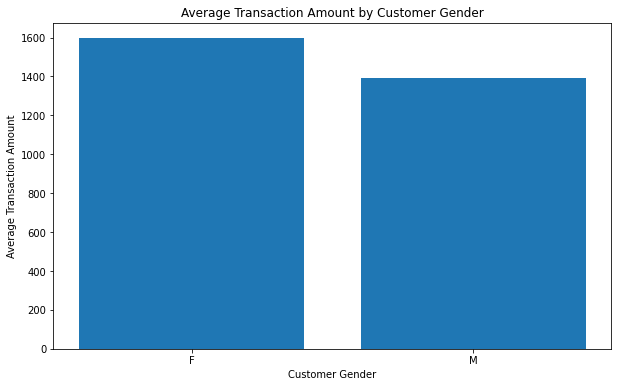

In [0]:
# Convert results to pandas DataFrame for plotting
average_transaction_amount_pd = pd.DataFrame({
    "CustGender": ["F", "M"],
    "AverageTransactionAmount": [average_transaction_amount_f[0]["AverageTransactionAmount"], average_transaction_amount_m[0]["AverageTransactionAmount"]]
})

# Print the result
print(average_transaction_amount_pd)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_transaction_amount_pd['CustGender'], average_transaction_amount_pd['AverageTransactionAmount'])
plt.xlabel('Customer Gender')
plt.ylabel('Average Transaction Amount')
plt.title('Average Transaction Amount by Customer Gender')
plt.xticks(rotation=0)
plt.show()

### Inference:
- This insight reveals the spending patterns across different genders. Businesses can leverage this information to create gender-specific marketing strategies and promotions. 
- Understanding gender-wise transaction distribution helps in better product positioning and customer segmentation.

### Insight 5: Age Wise distribution of Transactions

In [0]:
# Show the resulting DataFrame
df_clean.select('CustomerID', 'CustomerDOB', 'Age').show()

+----------+-----------+---+
|CustomerID|CustomerDOB|Age|
+----------+-----------+---+
|  C5841053| 1994-01-10| 22|
|  C2142763| 1957-04-04| 59|
|  C4417068| 1996-11-26| 19|
|  C5342380| 1973-09-14| 43|
|  C9031234| 1988-03-24| 28|
|  C1536588| 1972-10-08| 44|
|  C7126560| 1992-01-26| 24|
|  C1220223| 1982-01-27| 34|
|  C8536061| 1988-04-19| 28|
|  C6638934| 1984-06-22| 32|
|  C5430833| 1982-07-22| 34|
|  C6939838| 1988-07-07| 28|
|  C6339347| 1978-06-13| 38|
|  C8327851| 1992-01-05| 24|
|  C7917151| 1978-03-24| 38|
|  C8334633| 1968-07-10| 48|
|  C8967349| 1989-07-16| 27|
|  C3732016| 1991-01-11| 25|
|  C8999019| 1985-06-24| 31|
|  C6121429| 1993-04-20| 23|
+----------+-----------+---+
only showing top 20 rows



In [0]:
# Filter out below 18 Customers
df_clean = df_clean.filter(col('Age') >= 0)

# Group by Age and calculate the total transaction amount
age_transaction_amount = df_clean.groupBy('Age') \
    .agg(_sum('TransactionAmount').alias('TotalTransactionAmount'))

# Sort by Age in ascending order
age_transaction_amount_sorted = age_transaction_amount.orderBy('Age')
age_transaction_amount_sorted.show()

+---+----------------------+
|Age|TotalTransactionAmount|
+---+----------------------+
| 18|     3379760.639811814|
| 19|     6185261.208389897|
| 20|  1.0194237732445717E7|
| 21|  1.6998749389118526E7|
| 22|   3.082338360715559E7|
| 23|  4.8184861210766725E7|
| 24|  5.7853079700623326E7|
| 25|   7.015013450244173E7|
| 26|   7.443658823330972E7|
| 27|   7.635318123033693E7|
| 28|   7.892949530817592E7|
| 29|   7.550104069000062E7|
| 30|   7.031162741152465E7|
| 31|    7.19741072724357E7|
| 32|  5.9886382874821745E7|
| 33|   5.964563159685418E7|
| 34|   5.152132211598749E7|
| 35|   4.524229655536425E7|
| 36|   4.480336661406404E7|
| 37|  4.1957260750810504E7|
+---+----------------------+
only showing top 20 rows



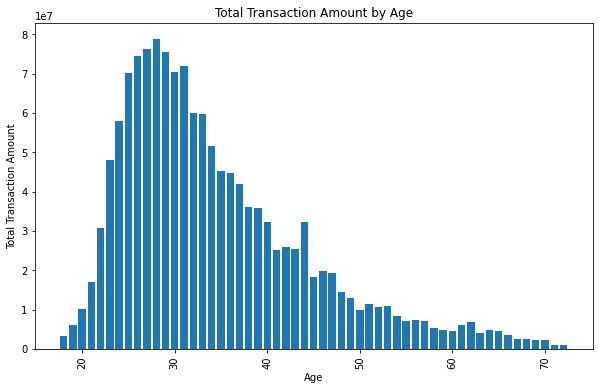

In [0]:
# Convert to Pandas DataFrame for plotting
age_transaction_amount_pd = age_transaction_amount_sorted.toPandas()

# Plotting the total transaction amount for each age
plt.figure(figsize=(10, 6))
plt.bar(age_transaction_amount_pd['Age'], age_transaction_amount_pd['TotalTransactionAmount'])
plt.xlabel('Age')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount by Age')
plt.xticks(rotation=90)
plt.show()

###Inference:
- This insight provides information on the average financial standing of customers across different locations. 
- It can help businesses identify regions with high or low financial activity and tailor their services accordingly. 
- For instance, areas with higher average balances might be targeted with premium services or investment opportunities.

### Insight 6: Age and Gender Wise distribution of Transactions

In [0]:
# Group by Age and Gender, and calculate the total transaction amount
age_gender_transaction_amount = df_clean.groupBy('Age', 'CustGender') \
    .agg(_sum('TransactionAmount').alias('TotalTransactionAmount'))

# Sort by Age in ascending order
age_gender_transaction_amount_sorted = age_gender_transaction_amount.orderBy('Age', 'CustGender')

# Convert to Pandas DataFrame for plotting
age_gender_transaction_amount_pd = age_gender_transaction_amount_sorted.toPandas()
age_gender_transaction_amount_sorted.show()

+---+----------+----------------------+
|Age|CustGender|TotalTransactionAmount|
+---+----------+----------------------+
| 18|         F|     662546.2903535366|
| 18|         M|     2717214.349458277|
| 19|         F|    1752010.9309357405|
| 19|         M|     4433250.277454156|
| 20|         F|     2732522.531746626|
| 20|         M|     7461715.200699091|
| 21|         F|     5960250.482523799|
| 21|         M|  1.1038498906594727E7|
| 22|         F|   1.140652625813374E7|
| 22|         M|  1.9416857349021852E7|
| 23|         F|   2.019187832913637E7|
| 23|         M|  2.7992982881630354E7|
| 24|         F|  2.1275710342226267E7|
| 24|         M|   3.657736935839706E7|
| 25|         F|  2.6947458542297393E7|
| 25|         M|   4.320267596014433E7|
| 26|         F|  2.6755852958956063E7|
| 26|         M|   4.768073527435365E7|
| 27|         F|  2.6653051630580485E7|
| 27|         M|   4.970012959975645E7|
+---+----------+----------------------+
only showing top 20 rows



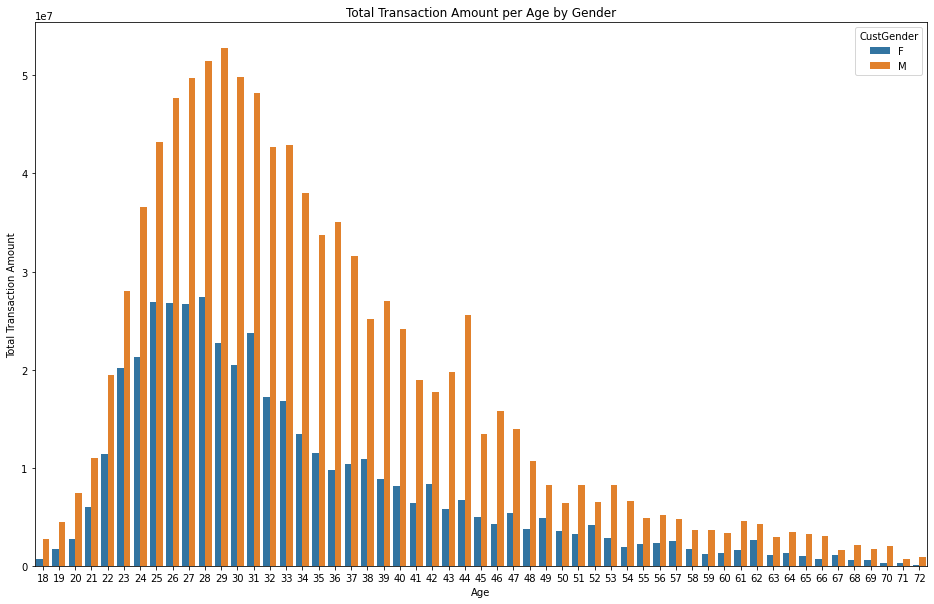

In [0]:
# Plotting the total transaction amount for each age by gender
plt.figure(figsize=(16, 10))
sns.barplot(data=age_gender_transaction_amount_pd, x='Age', y='TotalTransactionAmount', hue='CustGender')
plt.xlabel('Age')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount per Age by Gender')
plt.xticks()
plt.legend(title='CustGender')
plt.show()

###Inference:
- This insight highlights the maximum transaction amounts recorded each day. 
- It helps businesses identify peak transaction days and understand the factors contributing to these peaks. 
- This can be useful for planning promotions, understanding customer behavior patterns, and managing resources effectively.

### Insight 7: Total Customer Balance as for Age


In [0]:
# Group by Age and Gender, and calculate the total CustAccountBalance amount
age_gender_CustAccountBalance = df_clean.groupBy('Age', 'CustGender') \
    .agg(_sum('CustAccountBalance').alias('TotalCustAccountBalance'))

# Sort by Age in ascending order
age_gender_CustAccountBalance_sorted = age_gender_CustAccountBalance.orderBy('Age', 'CustGender')

# Convert to Pandas DataFrame for plotting
age_gender_CustAccountBalance_pd = age_gender_CustAccountBalance_sorted.toPandas()
age_gender_CustAccountBalance_sorted.show()

+---+----------+-----------------------+
|Age|CustGender|TotalCustAccountBalance|
+---+----------+-----------------------+
| 18|         F|   3.0245806736161232E7|
| 18|         M|    5.000464518670202E7|
| 19|         F|   5.5995510823536694E7|
| 19|         M|   1.4203094643334365E8|
| 20|         F|    1.101503582274856E8|
| 20|         M|    3.039904318946406E8|
| 21|         F|    2.387002526357839E8|
| 21|         M|      3.6448499066074E8|
| 22|         F|    3.361121654932011E8|
| 22|         M|    6.864839499874172E8|
| 23|         F|     6.57996479907857E8|
| 23|         M|   1.0178061091027538E9|
| 24|         F|    8.469860601696023E8|
| 24|         M|    1.934766203987327E9|
| 25|         F|   1.0653341436048687E9|
| 25|         M|   1.8541643955395005E9|
| 26|         F|   1.1586133727201886E9|
| 26|         M|   2.5660321843717723E9|
| 27|         F|   1.2459945832014015E9|
| 27|         M|    3.200705747092247E9|
+---+----------+-----------------------+
only showing top

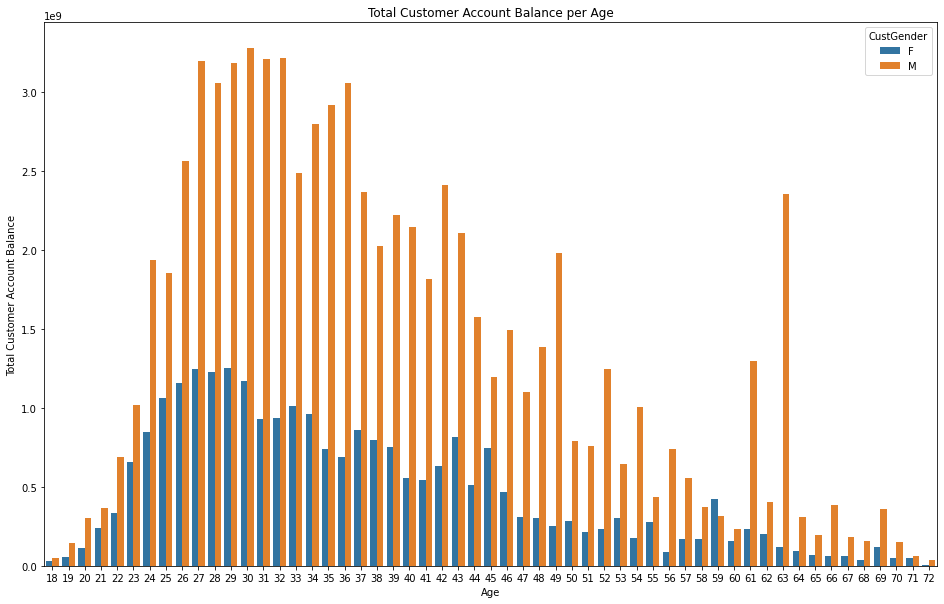

In [0]:
# Plotting the total transaction amount for each age by gender
plt.figure(figsize=(16, 10))
sns.barplot(data=age_gender_CustAccountBalance_pd, x='Age', y='TotalCustAccountBalance', hue='CustGender')
plt.xlabel('Age')
plt.ylabel('Total Customer Account Balance')
plt.title('Total Customer Account Balance per Age')
plt.xticks()
plt.legend(title='CustGender')
plt.show()

###Inference:
- This insight reveals the age distribution of customers. 
- Understanding the age demographics helps businesses tailor their products, services, and marketing strategies to suit different age groups. 
- For example, younger age groups might prefer more tech-savvy solutions, while older age groups might value more traditional services. 
- This demographic analysis is crucial for market segmentation and targeting.

#### Additional insights

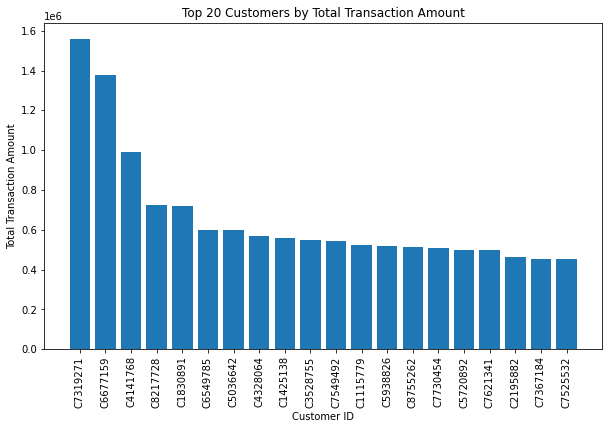

In [0]:
# Assuming 'total_transaction_amount_pd' is a DataFrame with customer transaction data

# Filter unrealistic dates and fill missing values
df_filtered = bank_df.filter(col("CustomerDOB") > lit("1900-01-01"))
df_filtered = df_filtered.fillna({"CustAccountBalance": 0, "TransactionAmount": 0})

# Calculate total transaction amount per customer
total_transaction_amount = df_filtered.groupBy("CustomerID").sum("TransactionAmount")
total_transaction_amount_pd = total_transaction_amount.toPandas()

# Select top N customers by transaction amount
top_n = 20
top_customers = total_transaction_amount_pd.nlargest(top_n, 'sum(TransactionAmount)')

# Plot the top N customers
plt.figure(figsize=(10, 6))
plt.bar(top_customers['CustomerID'], top_customers['sum(TransactionAmount)'])
plt.xlabel('Customer ID')
plt.ylabel('Total Transaction Amount')
plt.title('Top {} Customers by Total Transaction Amount'.format(top_n))
plt.xticks(rotation=90)
plt.show()


### Key Lessons Learned in the Assignment
**Data Cleaning and Data Preprocessing is very important:**

- Handling missing values, formatting inconsistant data are crucial steps that cannot be overlooked. 
- This project reinforced the importance of thorough data cleaning and preprocessing to produce reliable and valid insights.


**Efficiency in Big Data Processing with PySpark:**
 
- PySpark enabled us to handle and process large volumes of data quickly. 
- Learning to use PySpark efficiently, including operations like partitioning, filtering, and using appropriate aggregations, was a significant takeaway that improved both performance and scalability of data processing tasks.

**Effective Visualization and Interpretation:**

- Visualization is also very important in making data insights understandable. 
- Using libraries like Matplotlib and Seaborn helped in creating informative plots, which helped us in the interpretation and communication of complex data insights.
- This is essential for driving data-informed business decisions.

###Summary of Accomplishments
In this project, we conducted an data analysis of customer transaction data using PySpark, derived business insights with complex operations including filtering, projection, group by, joins, partition over ranking functions, moving averages,etc. We used Matplotlib and Seaborn libraries to provide data vizualizations and comprehensive view of the findings. 

Key accomplishments include:

1. **Total Transaction Amount per Customer Location:** Identified regions with the highest and lowest transaction amounts to guide location-specific strategies.
2. **Top 3 Customers by Transaction Amount in Each Location:** Highlighted high-value customers in different locations to aid in customer retention and targeted marketing.
3. **Moving Average of Transaction Amount for Each Customer:** Tracked transaction trends for individual customers to understand their behavior over time.
4. **Gender-wise Distribution of Transactions:** Analyzed spending patterns across genders to inform gender-specific marketing strategies.
5. **Average Account Balance per Location:** Provided insights into the financial standing of customers across different regions.
6. **Highest Transaction Amount per Day:** Identified peak transaction days to understand customer behavior patterns.
Customer Age Distribution: Analyzed the age demographics of customers to tailor products and marketing strategies accordingly.


###Lessons Learned
- **Data Cleaning and Preprocessing:** The importance of thorough data cleaning and preprocessing was evident. Handling missing values, formatting dates, and ensuring data consistency were crucial steps to ensure accurate analysis.
- **Performance Optimization:** Efficient use of PySpark operations significantly improved the performance of data processing tasks. Techniques like partitioning and using appropriate aggregations were key to managing large datasets.
- **Complex Operations in PySpark:** Understanding and implementing complex operations such as window functions, moving averages, and ranking functions provided deeper insights into customer data.
- **Visualization Techniques:** The ability to visualize data effectively using Matplotlib and Seaborn helped in better interpretation of the results and facilitated clearer communication of findings.
- **Business Insights and Decision Making:** Deriving actionable business insights from data analysis is critical.

###Conclusion
By leveraging PySpark for data processing and Python for visualization, we were able to derive meaningful insights that help for decision-making. This analysis not only highlighted the current state of customer transactions but also provided a foundation for future data-driven strategies.